In [29]:
import csv
import itertools
import os
import re
from collections import Counter
from collections import defaultdict
from datetime import datetime
from datetime import timedelta
from random import shuffle
from string import punctuation

import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.tslib import Timestamp

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 100
matplotlib.rcParams['lines.linewidth'] = 1.0

In [3]:
from IPython.display import display

def print_full_df(df):
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')

# Grupos

## Socios activos 2016

In [4]:
# 1.       CTA: categoría para niños y jóvenes hasta bachillerato
# 2.       CTI: categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)
# 3.       CTB: público general (solo permite préstamo de libros)
# 4.       CTC: público en general (permite préstamo de libros y material audiovisual)
# 5.       CTF: categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia
# 6.       CE1, CE2, CE2: categorías empresariales (solo para instituciones)
# 7.       CIS: categoría Inclusión Social
# 8.       CTU: categoría Universitaria
# 9.       VIP: Investigadores, préstamo de 30 materiales (libros y material audiovisual)

#      Categoría de lector: CE1 Categoría empresarial                                   218
#      Categoría de lector: CE2 Categoría empresarial 2                                   5
#      Categoría de lector: CEM Categoría Empleado/Pensionado                          1593
#      Categoría de lector: CIN Categoría Interbibliotecario                            128
#      Categoría de lector: CIP Categoría Investigador                                  351
#      Categoría de lector: CIS Categoría Inclusión Preferencial                      15974
#      Categoría de lector: CIV Categoría Investigadores                                 72
#      Categoría de lector: CML Categoría Mediador de Proyectos Culturales                2
#      Categoría de lector: CSU Categoría Sucursal                                       91
#      Categoría de lector: CTA Categoría Básica A                                    10610
#      Categoría de lector: CTB Categoría B                                            1359
#      Categoría de lector: CTC Categoría C                                             224
#      Categoría de lector: CTF Categoría familiar                                     1105
#      Categoría de lector: CTI Categoría Infantil                                     1004
#      Categoría de lector: CTU Categoría General                                     17402
#      Categoría de lector: PTE PROCESOS TÉCNICOS                                        95

In [5]:
%%time

dtypes = {
    'Sucursal': str,
    'Tratamiento': str,
    'Barrio': str,
    'Ciudad': str,
    'CATEG': str,
    'Ocupación1': str,
    'Nivel Estudio1': str,
    'Área de Estudio1': str,
    'Edad': 'category',
}

perfiles_df = pd.read_csv(
    'valores_grupos_2016.csv', header=0, dtype=dtypes)
# perfiles_df = perfiles_df.fillna('')

CPU times: user 69.5 ms, sys: 3.3 ms, total: 72.8 ms
Wall time: 72.9 ms


In [6]:
perfiles_df.shape

(50272, 9)

In [7]:
perfiles_df.head()

,Sucursal,Tratamiento,Barrio,Ciudad,CATEG,Ocupación1,Nivel Estudio1,Área de Estudio1,Edad
0,BLAA,OTRO,chapinero,bogota,CIN,universidad,OTRO,OTRO,OTRO
1,BLAA,sra.,OTRO,bogota,CEM,pensionado,OTRO,OTRO,50-64
2,BLAA,sra.,icata,bogota,CEM,empleado,profesional,filosofía y letras,OTRO
3,ARM,sr.,OTRO,OTRO,CEM,empleado,profesional,economía,50-64
4,BLAA,sr.,soledad,bogota,CEM,OTRO,OTRO,OTRO,OTRO


# Estratos

From http://www.sdp.gov.co/portal/page/portal/PortalSDP/actualidad-SDP-home/Segregacion_Socioeconomica_Espacio_Urbano_Bogota_Junio_0.pdf

In [8]:
estratos_dict_aux = defaultdict(list)

previous = ''
with open('estratos_UPZ.txt') as f:
    for line in f:
        line = line.strip().strip('-')
        if line.isupper():
            previous += line
        elif line.isdigit() and 1 <= int(line) <= 6 and previous.isupper():
            estratos_dict_aux[previous].append(int(line))
            previous = ''

In [9]:
change_dict = {
    'ALFONSOLOPEZ': 'ALFONSO LOPEZ',
    'BOYACAREAL': 'BOYACA REAL',
    'CIUDADJARDIN': 'CIUDAD JARDIN',
    'CIUDADMONTES': 'CIUDAD MONTES',
    'CIUDAD SALITREOCCIDENTAL': 'CIUDAD SALITRE OCCIDENTAL',
    'CIUDAD SALITREORIENTAL': 'CIUDAD SALITRE ORIENTAL',
    'CIUDADSALITRE OCCIDENTAL': 'CIUDAD SALITRE OCCIDENTAL',
    'CIUDADSALITREORIENTAL': 'CIUDAD SALITRE ORIENTAL',
    'DOCE DEOCTUBRE': 'DOCE DE OCTUBRE',
    'GARCESNAVAS': 'GARCES NAVAS',
    'GRANJAS DETECHO': 'GRANJAS DE TECHO',
    'KENNEDYCENTRAL': 'KENNEDY CENTRAL',
    'MARCO FIDELSUAREZ': 'MARCO FIDEL SUAREZ',
    'MINUTO DEDIOS': 'MINUTO DE DIOS',
    'PARDORUBIO': 'PARDO RUBIO',
    'QUINTAPAREDES': 'QUINTA PAREDES',
    'SAGRADOCORAZON': 'SAGRADO CORAZON',
}

estratos_dict = {}

for e in estratos_dict_aux:
    if e in change_dict:
        r = change_dict[e]
    else:
        r = e
    r = r.lower()
    if r.startswith('el ') or r.startswith('la '):
        r = r[3:]
    elif r.startswith('los ') or r.startswith('las '):
        r = r[4:]
    
    estratos_dict[r] = estratos_dict_aux[e][0]

From Ana

In [26]:
# Add barrios de Ana a los míos en estratos_dict

In [110]:
estratos_dict_inv = defaultdict(list)
for k in estratos_dict:
    estratos_dict_inv[estratos_dict[k]].append(k)
estratos_dict_inv = dict(estratos_dict_inv)

N = 2

def ran():
    return 0.5

def my_shuffle(ls, random=None):
    rs = list(ls)
    shuffle(rs, random)
    return rs

def my_sample(ls, k, random=None):
    return my_shuffle(ls, random)[:k]

# Example of use:
# ls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# my_shuffle(ls, random=lambda: 0.5)
# > [1, 6, 2, 8, 3, 7, 4, 9, 5]
# my_sample([1, 6, 2, 8, 3, 7, 4, 9, 5], 2, random=lambda: 0.5)
# > [1, 7]
# my_sample([1, 6, 2, 8, 3, 7, 4, 9, 5], 12, random=lambda: 0.5)
# > 1, 7, 6, 9, 2, 4, 8, 5, 3]

selected_barrios_dict = {}
for k in estratos_dict_inv:
    ls = my_sample(estratos_dict_inv[k], N, random=lambda: 0.5)
    for b in ls:
        selected_barrios_dict[b] = k

In [111]:
selected_barrios_dict

{'alcazares': 3,
 'chico lago': 6,
 'ciudad salitre occidental': 4,
 'ciudad salitre oriental': 4,
 'cruces': 2,
 'fontibon sanpablo': 2,
 'jerusalem': 1,
 'refugio': 6,
 'tesoro': 1,
 'usaquen': 5,
 'venecia': 3}

In [112]:
perfiles_bogota_estratos = perfiles_df[perfiles_df['Barrio'].isin(selected_barrios_dict)].copy()

In [113]:
perfiles_bogota_estratos['Estrato'] = perfiles_bogota_estratos.apply(lambda x: estratos_dict[x['Barrio']], axis=1)

In [115]:
perfiles_bogota_estratos.head()

,Sucursal,Tratamiento,Barrio,Ciudad,CATEG,Ocupación1,Nivel Estudio1,Área de Estudio1,Edad,Estrato
147,BLAA,sra.,venecia,bogota,CEM,pensionado,OTRO,OTRO,OTRO,3
396,BLAA,sr.,venecia,bogota,CTF,docente,profesional,cine fotografía y televisión,40-49,3
635,BLAA,sr.,venecia,bogota,CTB,estudiante,maestría,geografía,40-49,3
709,BLAA,sr.,venecia,bogota,CTU,independiente,profesional,artes plásticas,50-64,3
716,BLAA,sr.,venecia,bogota,CTU,independiente,profesional,psicología,40-49,3


In [116]:
perfiles_bogota_estratos.groupby('Estrato')['Barrio'].count()

Estrato
1     17
2     70
3    128
4      4
5     22
6     31
Name: Barrio, dtype: int64

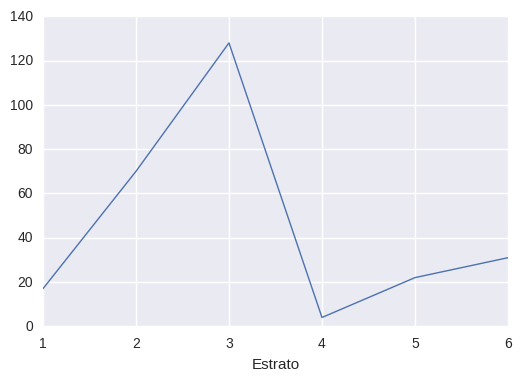

In [117]:
perfiles_bogota_estratos.groupby('Estrato')['Barrio'].count().plot()